In [ ]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

np.random.seed(42)

In [ ]:
# Cell 2: Parameters and Data
N = 3100  # Number of data points
M = 31  # Number of clusters
beta_min = 0.001
beta_max = 1000.0
tau = 1.05

# X = np.random.randn(N, 2)               # 2D input data
X = np.loadtxt("D31.txt")[:, :2]
rho = np.ones(N) / N  # Uniform weights

# Initialize cluster centers randomly
Y = np.random.randn(M, 2)

# Random probabilities p(l | j, i): shape (M, M, N)
p_l_given_ji = np.full((N, M, M), 0.2 / (M - 1))
for i in range(N):
    for k in range(M):
        p_l_given_ji[i, k, :] = 0.2 / (M - 1)
        p_l_given_ji[i, k, k] = 0.8
# Normalize so that sum over l is 1 for each (i, k)
p_l_given_ji /= np.sum(p_l_given_ji, axis=2, keepdims=True)

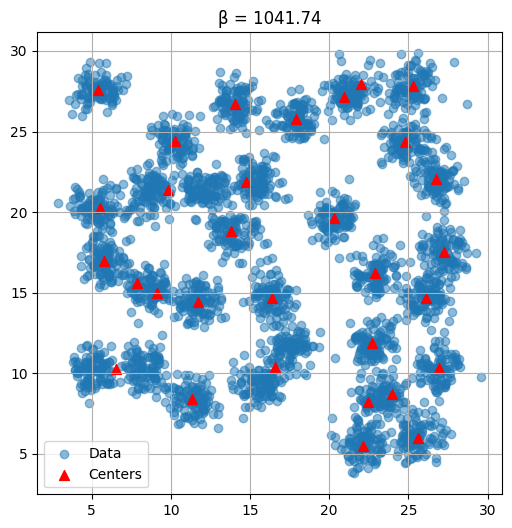

In [ ]:
# Cell 4: Main loop with policy and y_l updates
beta = beta_min
Y_old = Y.copy() + 1e6
Y_list = [Y]
while beta <= beta_max:
    counter = 0
    while np.linalg.norm(Y - Y_old) / np.linalg.norm(Y_old) > 1e-6:
        # update policy
        D = cdist(X, Y, "sqeuclidean", out=None)
        D_bar = np.sum(np.tile(D[:, None, :], (1, M, 1)) * p_l_given_ji, axis=2)
        mins = np.min(D_bar, axis=1, keepdims=True)
        D_bar_normalized = D_bar - mins
        pi = np.exp(-beta * D_bar_normalized)
        pi /= np.sum(pi, axis=1, keepdims=True)
        # update cluster centers
        p_y_x = pi * np.tile(rho[:, None], (1, M))
        p_y = np.sum(p_y_x, axis=0)
        p_x_given_y = p_y_x / np.tile(p_y[None, :], (N, 1))
        Y = p_x_given_y.T @ X

        counter += 1
        Y_old = Y.copy()
    Y_list.append(Y.copy())
    beta *= tau
    Y += np.random.randn(M, 2) * 0.001  # Add small noise to avoid local minima
    # print(
    #         f"Iteration {counter}, beta: {beta:.2f}, norm: {np.linalg.norm(Y - Y_old):.6f}"
    #     )
    # Plot for GIF
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Data")
ax.scatter(Y[:, 0], Y[:, 1], color="red", s=50, marker="^", label="Centers")
ax.set_title(f"β = {beta:.2f}")
ax.legend()
ax.grid(True)

In [ ]:
from animator import animate_Clusters

animate_Clusters(
    X,
    Y_list,
    [np.zeros(N, dtype=int) for _ in range(len(Y_list))],
    figuresize=(6, 5),
    interval=200,
    save_path="phase_transition_clustering.gif",
)